In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [2]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [3]:
class FTTransformer_2(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, d_model, dropout):
        super(FTTransformer_2, self).__init__()
        self.input_dim = input_dim

        # 入力を特徴トークンとして埋め込む
        self.embedding = nn.Linear(input_dim, d_model)
        
        # Transformerエンコーダ層
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout),
            num_layers=num_layers
        )
        
        # 出力層
        self.fc = nn.Linear(d_model, 1)
        
    def forward(self, x):
        # 入力を埋め込み
        # [batch_size, input_dim] -> [batch_size, seq_len=1, d_model]
        x = self.embedding(x).unsqueeze(1)
        
        # 次元を変更 [batch_size, seq_len, d_model] -> [seq_len, batch_size, d_model]
        x = x.permute(1, 0, 2)
        
        # Transformerエンコーダに通す
        x = self.transformer(x)
        
        # 最後のトークンを取得して分類
        # [seq_len, batch_size, d_model] -> [batch_size, d_model]
        x = x.mean(dim=0)  # 平均を取る
        x = self.fc(x)  # 出力層
        return torch.sigmoid(x)


学習データセットの作成

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

Optunaの設定

In [ ]:
import optuna

# 目的関数の定義
def objective(trial):
    # ハイパーパラメータのサンプリング
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8])
    num_layers = trial.suggest_int('num_layers', 1, 5)
    d_model = trial.suggest_categorical('d_model', [32, 64, 128])
    dropout = trial.suggest_float('dropout', 0.1, 0.5,step=0.05)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)

    model = FTTransformer_2(input_dim=X_train.shape[1], 
                           num_heads=num_heads, 
                           num_layers=num_layers, 
                           d_model=d_model, 
                           dropout=dropout)
    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    
    num_epochs=100
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs,y_batch )
            loss.backward()
            optimizer.step()
    
    model.eval()
    val_true, val_pred, val_prob = [], [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val).squeeze()
            predictions = (val_outputs >= 0.5).float()
            val_true.extend(y_val.cpu().numpy())
            val_pred.extend(predictions.cpu().numpy())
            val_prob.extend(val_outputs.cpu().numpy())


    accuracy = accuracy_score(val_true, val_pred)
    precision = precision_score(val_true, val_pred)
    recall = recall_score(val_true, val_pred)
    f1 = f1_score(val_true, val_pred)
    mcc = matthews_corrcoef(val_true, val_pred)
    specificity = recall_score(val_true, val_pred, pos_label=0)

    # ログ
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')
    
    return precision

In [6]:
# 使用可能なGPUの数を取得
num_gpus = torch.cuda.device_count()

if num_gpus == 0:
    print("使用可能なGPUはありません。")
else:
    print(f"使用可能なGPUの数: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  メモリ使用状況: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB / {torch.cuda.get_device_properties(i).total_memory / 1024**2:.2f} MB")
        print(f"  CUDA対応バージョン: {torch.cuda.get_device_properties(i).major}.{torch.cuda.get_device_properties(i).minor}")


使用可能なGPUの数: 2
GPU 0: NVIDIA GeForce GTX 1080 Ti
  メモリ使用状況: 0.00 MB / 11169.31 MB
  CUDA対応バージョン: 6.1
GPU 1: NVIDIA GeForce GTX 1080 Ti
  メモリ使用状況: 0.00 MB / 11172.19 MB
  CUDA対応バージョン: 6.1


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)


print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)


[I 2024-11-28 19:03:04,066] A new study created in memory with name: no-name-64941b54-9b7b-42b9-9ceb-5e926ababa87
/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for 

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:07:56,772] Trial 1 finished with value: 0.0 and parameters: {'num_heads': 2, 'num_layers': 3, 'd_model': 128, 'dropout': 0.4, 'learning_rate': 0.0010031949336101376, 'weight_decay': 5.773354730508334e-05}. Best is trial 0 with value: 0.0.
/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated i

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:09:50,022] Trial 2 finished with value: 0.0 and parameters: {'num_heads': 2, 'num_layers': 3, 'd_model': 64, 'dropout': 0.5, 'learning_rate': 0.05361141020808341, 'weight_decay': 0.09776633962502969}. Best is trial 0 with value: 0.0.
/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:10:46,753] Trial 3 finished with value: 0.6278481012658228 and parameters: {'num_heads': 8, 'num_layers': 1, 'd_model': 64, 'dropout': 0.4, 'learning_rate': 0.004816304195252757, 'weight_decay': 4.3414897626633526e-05}. Best is trial 3 with value: 0.6278481012658228.


Accuracy: 58.12%
Precision: 0.4610
Recall: 0.9841
F1 Score: 0.6278
Matthews Correlation Coefficient: 0.3851
Specificity: 0.3556


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:11:43,048] Trial 4 finished with value: 0.54785478

Accuracy: 60.97%
Precision: 0.4689
Recall: 0.6587
F1 Score: 0.5479
Matthews Correlation Coefficient: 0.2312
Specificity: 0.5822


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:12:39,756] Trial 5 finished with value: 0.47692307

Accuracy: 61.25%
Precision: 0.4627
Recall: 0.4921
F1 Score: 0.4769
Matthews Correlation Coefficient: 0.1699
Specificity: 0.6800


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:13:37,924] Trial 6 finished with value: 0.62814070

Accuracy: 57.83%
Precision: 0.4596
Recall: 0.9921
F1 Score: 0.6281
Matthews Correlation Coefficient: 0.3891
Specificity: 0.3467


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/skle

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:17:59,669] Trial 8 finished with value: 0.453781512605042 and parameters: {'num_heads': 2, 'num_layers': 3, 'd_model': 128, 'dropout': 0.1, 'learning_rate': 0.00014939526519459163, 'weight_decay': 0.00021410297954499222}. Best is trial 6 with value: 0.628140703517588.


Accuracy: 62.96%
Precision: 0.4821
Recall: 0.4286
F1 Score: 0.4538
Matthews Correlation Coefficient: 0.1758
Specificity: 0.7422


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:20:45,472] Trial 9 finished with value: 0.61979166

Accuracy: 58.40%
Precision: 0.4612
Recall: 0.9444
F1 Score: 0.6198
Matthews Correlation Coefficient: 0.3551
Specificity: 0.3822


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/skle

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:23:13,529] Trial 11 finished with value: 0.6190476190476191 and parameters: {'num_heads': 2, 'num_layers': 1, 'd_model': 64, 'dropout': 0.45000000000000007, 'learning_rate': 0.004156890865446536, 'weight_decay': 1.1889569065900263e-05}. Best is trial 6 with value: 0.628140703517588.


Accuracy: 58.97%
Precision: 0.4643
Recall: 0.9286
F1 Score: 0.6190
Matthews Correlation Coefficient: 0.3503
Specificity: 0.4000


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:24:42,033] Trial 12 finished with value: 0.6068601

Accuracy: 57.55%
Precision: 0.4545
Recall: 0.9127
F1 Score: 0.6069
Matthews Correlation Coefficient: 0.3201
Specificity: 0.3867


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/skle

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:27:08,995] Trial 14 finished with value: 0.41379310344827586 and parameters: {'num_heads': 4, 'num_layers': 1, 'd_model': 32, 'dropout': 0.4, 'learning_rate': 0.0013623631013850485, 'weight_decay': 0.003771775120462435}. Best is trial 6 with value: 0.628140703517588.


Accuracy: 61.25%
Precision: 0.4528
Recall: 0.3810
F1 Score: 0.4138
Matthews Correlation Coefficient: 0.1287
Specificity: 0.7422


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/skle

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:29:35,270] Trial 16 finished with value: 0.3904761904761905 and parameters: {'num_heads': 2, 'num_layers': 1, 'd_model': 32, 'dropout': 0.35, 'learning_rate': 0.0002715999397947536, 'weight_decay': 0.00025095282406005693}. Best is trial 6 with value: 0.628140703517588.


Accuracy: 63.53%
Precision: 0.4881
Recall: 0.3254
F1 Score: 0.3905
Matthews Correlation Coefficient: 0.1510
Specificity: 0.8089


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/skle

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:33:24,892] Trial 18 finished with value: 0.0 and parameters: {'num_heads': 8, 'num_layers': 2, 'd_model': 64, 'dropout': 0.2, 'learning_rate': 0.023394299043935158, 'weight_decay': 0.0018134924816365474}. Best is trial 6 with value: 0.628140703517588.
/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:34:22,102] Trial 19 finished with value: 0.6246719160104987 and parameters: {'num_heads': 4, 'num_layers': 1, 'd_model': 32, 'dropout': 0.35, 'learning_rate': 0.0030837600183322477, 'weight_decay': 0.00045996302569490055}. Best is trial 6 with value: 0.628140703517588.


Accuracy: 59.26%
Precision: 0.4667
Recall: 0.9444
F1 Score: 0.6247
Matthews Correlation Coefficient: 0.3659
Specificity: 0.3956


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/skle

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:37:40,625] Trial 21 finished with value: 0.4435146443514644 and parameters: {'num_heads': 4, 'num_layers': 1, 'd_model': 32, 'dropout': 0.35, 'learning_rate': 0.002545293891575249, 'weight_decay': 0.0004231226923502512}. Best is trial 6 with value: 0.628140703517588.


Accuracy: 62.11%
Precision: 0.4690
Recall: 0.4206
F1 Score: 0.4435
Matthews Correlation Coefficient: 0.1581
Specificity: 0.7333


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:38:39,048] Trial 22 finished with value: 0.6227848

Accuracy: 57.55%
Precision: 0.4572
Recall: 0.9762
F1 Score: 0.6228
Matthews Correlation Coefficient: 0.3711
Specificity: 0.3511


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:40:08,205] Trial 23 finished with value: 0.6004842

Accuracy: 52.99%
Precision: 0.4321
Recall: 0.9841
F1 Score: 0.6005
Matthews Correlation Coefficient: 0.3226
Specificity: 0.2756


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:41:05,522] Trial 24 finished with value: 0.5823529

Accuracy: 59.54%
Precision: 0.4626
Recall: 0.7857
F1 Score: 0.5824
Matthews Correlation Coefficient: 0.2700
Specificity: 0.4889


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:42:34,274] Trial 25 finished with value: 0.4197530

Accuracy: 59.83%
Precision: 0.4359
Recall: 0.4048
F1 Score: 0.4198
Matthews Correlation Coefficient: 0.1134
Specificity: 0.7067


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:43:31,599] Trial 26 finished with value: 0.6137566

Accuracy: 58.40%
Precision: 0.4603
Recall: 0.9206
F1 Score: 0.6138
Matthews Correlation Coefficient: 0.3371
Specificity: 0.3956


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:45:00,526] Trial 27 finished with value: 0.5249169

Accuracy: 59.26%
Precision: 0.4514
Recall: 0.6270
F1 Score: 0.5249
Matthews Correlation Coefficient: 0.1922
Specificity: 0.5733


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/skle

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:48:43,326] Trial 29 finished with value: 0.6182795698924731 and parameters: {'num_heads': 2, 'num_layers': 5, 'd_model': 64, 'dropout': 0.30000000000000004, 'learning_rate': 0.0008778490598292403, 'weight_decay': 0.00079664374408435}. Best is trial 6 with value: 0.628140703517588.


Accuracy: 59.54%
Precision: 0.4675
Recall: 0.9127
F1 Score: 0.6183
Matthews Correlation Coefficient: 0.3462
Specificity: 0.4178


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:49:40,543] Trial 30 finished with value: 0.5283018

Accuracy: 35.90%
Precision: 0.3590
Recall: 1.0000
F1 Score: 0.5283
Matthews Correlation Coefficient: 0.0000
Specificity: 0.0000


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:50:39,801] Trial 31 finished with value: 0.6169154

Accuracy: 56.13%
Precision: 0.4493
Recall: 0.9841
F1 Score: 0.6169
Matthews Correlation Coefficient: 0.3611
Specificity: 0.3244


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:51:37,334] Trial 32 finished with value: 0.6184538

Accuracy: 56.41%
Precision: 0.4509
Recall: 0.9841
F1 Score: 0.6185
Matthews Correlation Coefficient: 0.3646
Specificity: 0.3289


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/skle

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:54:03,330] Trial 34 finished with value: 0.6218905472636815 and parameters: {'num_heads': 4, 'num_layers': 1, 'd_model': 32, 'dropout': 0.2, 'learning_rate': 0.008075591924620675, 'weight_decay': 6.136067893057416e-05}. Best is trial 6 with value: 0.628140703517588.


Accuracy: 56.70%
Precision: 0.4529
Recall: 0.9921
F1 Score: 0.6219
Matthews Correlation Coefficient: 0.3756
Specificity: 0.3289


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:55:59,231] Trial 35 finished with value: 0.4961832

Accuracy: 62.39%
Precision: 0.4779
Recall: 0.5159
F1 Score: 0.4962
Matthews Correlation Coefficient: 0.1972
Specificity: 0.6844


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 19:56:55,594] Trial 36 finished with value: 0.4268774

Accuracy: 58.69%
Precision: 0.4252
Recall: 0.4286
F1 Score: 0.4269
Matthews Correlation Coefficient: 0.1039
Specificity: 0.6756


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/skle

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:59:48,318] Trial 38 finished with value: 0.0 and parameters: {'num_heads': 2, 'num_layers': 1, 'd_model': 64, 'dropout': 0.25, 'learning_rate': 0.015485294184719512, 'weight_decay': 0.02112268170441046}. Best is trial 6 with value: 0.628140703517588.
/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been 

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:01:16,955] Trial 39 finished with value: 0.573134328358209 and parameters: {'num_heads': 8, 'num_layers': 2, 'd_model': 128, 'dropout': 0.15000000000000002, 'learning_rate': 0.0017138954063418482, 'weight_decay': 0.00016185149300338437}. Best is trial 6 with value: 0.628140703517588.


Accuracy: 59.26%
Precision: 0.4593
Recall: 0.7619
F1 Score: 0.5731
Matthews Correlation Coefficient: 0.2538
Specificity: 0.4978


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:02:14,583] Trial 40 finished with value: 0.6212121

Accuracy: 57.26%
Precision: 0.4556
Recall: 0.9762
F1 Score: 0.6212
Matthews Correlation Coefficient: 0.3676
Specificity: 0.3467


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:03:11,284] Trial 41 finished with value: 0.6278481

Accuracy: 58.12%
Precision: 0.4610
Recall: 0.9841
F1 Score: 0.6278
Matthews Correlation Coefficient: 0.3851
Specificity: 0.3556


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/skle

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:05:06,181] Trial 43 finished with value: 0.0 and parameters: {'num_heads': 4, 'num_layers': 1, 'd_model': 32, 'dropout': 0.25, 'learning_rate': 0.016905920968894615, 'weight_decay': 1.4623916706629475e-05}. Best is trial 6 with value: 0.628140703517588.
/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has be

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:06:03,343] Trial 44 finished with value: 0.629156010230179 and parameters: {'num_heads': 4, 'num_layers': 1, 'd_model': 32, 'dropout': 0.35, 'learning_rate': 0.006627644566678396, 'weight_decay': 9.131017287747577e-05}. Best is trial 44 with value: 0.629156010230179.


Accuracy: 58.69%
Precision: 0.4642
Recall: 0.9762
F1 Score: 0.6292
Matthews Correlation Coefficient: 0.3849
Specificity: 0.3689


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:07:32,175] Trial 45 finished with value: 0.5287356

Accuracy: 64.96%
Precision: 0.5111
Recall: 0.5476
F1 Score: 0.5287
Matthews Correlation Coefficient: 0.2507
Specificity: 0.7067


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:08:29,086] Trial 46 finished with value: 0.6259541

Accuracy: 58.12%
Precision: 0.4607
Recall: 0.9762
F1 Score: 0.6260
Matthews Correlation Coefficient: 0.3780
Specificity: 0.3600


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/skle

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 20:11:21,293] Trial 48 finished with value: 0.0 and parameters: {'num_heads': 2, 'num_layers': 3, 'd_model': 64, 'dropout': 0.4, 'learning_rate': 0.004863697187720049, 'weight_decay': 0.07340489235873472}. Best is trial 44 with value: 0.629156010230179.
/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been 

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:12:50,203] Trial 49 finished with value: 0.4864864864864865 and parameters: {'num_heads': 2, 'num_layers': 2, 'd_model': 64, 'dropout': 0.45000000000000007, 'learning_rate': 2.4102494563828798e-05, 'weight_decay': 7.774532225127663e-05}. Best is trial 44 with value: 0.629156010230179.


Accuracy: 62.11%
Precision: 0.4737
Recall: 0.5000
F1 Score: 0.4865
Matthews Correlation Coefficient: 0.1868
Specificity: 0.6889


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:13:47,106] Trial 50 finished with value: 0.6256410

Accuracy: 58.40%
Precision: 0.4621
Recall: 0.9683
F1 Score: 0.6256
Matthews Correlation Coefficient: 0.3746
Specificity: 0.3689


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:14:44,581] Trial 51 finished with value: 0.6278481

Accuracy: 58.12%
Precision: 0.4610
Recall: 0.9841
F1 Score: 0.6278
Matthews Correlation Coefficient: 0.3851
Specificity: 0.3556


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:15:43,094] Trial 52 finished with value: 0.3732057

Accuracy: 62.68%
Precision: 0.4699
Recall: 0.3095
F1 Score: 0.3732
Matthews Correlation Coefficient: 0.1287
Specificity: 0.8044


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:16:40,161] Trial 53 finished with value: 0.6212121

Accuracy: 57.26%
Precision: 0.4556
Recall: 0.9762
F1 Score: 0.6212
Matthews Correlation Coefficient: 0.3676
Specificity: 0.3467


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:17:37,375] Trial 54 finished with value: 0.6278481

Accuracy: 58.12%
Precision: 0.4610
Recall: 0.9841
F1 Score: 0.6278
Matthews Correlation Coefficient: 0.3851
Specificity: 0.3556


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:18:35,060] Trial 55 finished with value: 0.6194225

Accuracy: 58.69%
Precision: 0.4627
Recall: 0.9365
F1 Score: 0.6194
Matthews Correlation Coefficient: 0.3526
Specificity: 0.3911


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:20:03,168] Trial 56 finished with value: 0.6296296

Accuracy: 60.11%
Precision: 0.4722
Recall: 0.9444
F1 Score: 0.6296
Matthews Correlation Coefficient: 0.3767
Specificity: 0.4089


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:21:31,583] Trial 57 finished with value: 0.2622950

Accuracy: 61.54%
Precision: 0.4211
Recall: 0.1905
F1 Score: 0.2623
Matthews Correlation Coefficient: 0.0570
Specificity: 0.8533


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:23:01,901] Trial 58 finished with value: 0.5813953

Accuracy: 58.97%
Precision: 0.4587
Recall: 0.7937
F1 Score: 0.5814
Matthews Correlation Coefficient: 0.2662
Specificity: 0.4756


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:24:40,088] Trial 59 finished with value: 0.3738317

Accuracy: 61.82%
Precision: 0.4545
Recall: 0.3175
F1 Score: 0.3738
Matthews Correlation Coefficient: 0.1152
Specificity: 0.7867


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:26:33,148] Trial 60 finished with value: 0.5983379

Accuracy: 58.69%
Precision: 0.4596
Recall: 0.8571
F1 Score: 0.5983
Matthews Correlation Coefficient: 0.2985
Specificity: 0.4356


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:27:53,829] Trial 61 finished with value: 0.6206896

Accuracy: 62.39%
Precision: 0.4865
Recall: 0.8571
F1 Score: 0.6207
Matthews Correlation Coefficient: 0.3487
Specificity: 0.4933


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/skle

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:32:22,088] Trial 63 finished with value: 0.6176470588235294 and parameters: {'num_heads': 2, 'num_layers': 1, 'd_model': 64, 'dropout': 0.45000000000000007, 'learning_rate': 0.010530276266062106, 'weight_decay': 3.9329020003757035e-05}. Best is trial 56 with value: 0.6296296296296297.


Accuracy: 55.56%
Precision: 0.4468
Recall: 1.0000
F1 Score: 0.6176
Matthews Correlation Coefficient: 0.3702
Specificity: 0.3067


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:33:41,599] Trial 64 finished with value: 0.4677419

Accuracy: 62.39%
Precision: 0.4754
Recall: 0.4603
F1 Score: 0.4677
Matthews Correlation Coefficient: 0.1772
Specificity: 0.7156


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:35:01,570] Trial 65 finished with value: 0.6217616

Accuracy: 58.40%
Precision: 0.4615
Recall: 0.9524
F1 Score: 0.6218
Matthews Correlation Coefficient: 0.3614
Specificity: 0.3778


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/skle

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 20:37:34,874] Trial 67 finished with value: 0.6118251928020566 and parameters: {'num_heads': 2, 'num_layers': 1, 'd_model': 64, 'dropout': 0.35, 'learning_rate': 0.0024317096507926778, 'weight_decay': 7.046654805734114e-05}. Best is trial 56 with value: 0.6296296296296297.


Accuracy: 56.98%
Precision: 0.4525
Recall: 0.9444
F1 Score: 0.6118
Matthews Correlation Coefficient: 0.3369
Specificity: 0.3600


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:38:51,775] Trial 68 finished with value: 0.5569620

Accuracy: 60.11%
Precision: 0.4632
Recall: 0.6984
F1 Score: 0.5570
Matthews Correlation Coefficient: 0.2359
Specificity: 0.5467


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:40:54,912] Trial 69 finished with value: 0.4416666

Accuracy: 61.82%
Precision: 0.4649
Recall: 0.4206
F1 Score: 0.4417
Matthews Correlation Coefficient: 0.1532
Specificity: 0.7289


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:42:13,055] Trial 70 finished with value: 0.6237113

Accuracy: 58.40%
Precision: 0.4618
Recall: 0.9603
F1 Score: 0.6237
Matthews Correlation Coefficient: 0.3679
Specificity: 0.3733


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:43:31,710] Trial 71 finished with value: 0.6196473

Accuracy: 56.98%
Precision: 0.4539
Recall: 0.9762
F1 Score: 0.6196
Matthews Correlation Coefficient: 0.3641
Specificity: 0.3422


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:44:51,067] Trial 72 finished with value: 0.6278481

Accuracy: 58.12%
Precision: 0.4610
Recall: 0.9841
F1 Score: 0.6278
Matthews Correlation Coefficient: 0.3851
Specificity: 0.3556


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:46:08,643] Trial 73 finished with value: 0.6275510

Accuracy: 58.40%
Precision: 0.4624
Recall: 0.9762
F1 Score: 0.6276
Matthews Correlation Coefficient: 0.3814
Specificity: 0.3644


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:47:24,789] Trial 74 finished with value: 0.6121372

Accuracy: 58.12%
Precision: 0.4585
Recall: 0.9206
F1 Score: 0.6121
Matthews Correlation Coefficient: 0.3334
Specificity: 0.3911


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:48:44,822] Trial 75 finished with value: 0.6356589

Accuracy: 59.83%
Precision: 0.4713
Recall: 0.9762
F1 Score: 0.6357
Matthews Correlation Coefficient: 0.3986
Specificity: 0.3867


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:50:04,550] Trial 76 finished with value: 0.6221079

Accuracy: 58.12%
Precision: 0.4601
Recall: 0.9603
F1 Score: 0.6221
Matthews Correlation Coefficient: 0.3644
Specificity: 0.3689


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:51:22,689] Trial 77 finished with value: 0.5852272

Accuracy: 58.40%
Precision: 0.4558
Recall: 0.8175
F1 Score: 0.5852
Matthews Correlation Coefficient: 0.2713
Specificity: 0.4533


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:53:24,125] Trial 78 finished with value: 0.6297229

Accuracy: 58.12%
Precision: 0.4613
Recall: 0.9921
F1 Score: 0.6297
Matthews Correlation Coefficient: 0.3924
Specificity: 0.3511


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 20:56:02,035] Trial 79 finished with value: 0.3603603

Accuracy: 59.54%
Precision: 0.4167
Recall: 0.3175
F1 Score: 0.3604
Matthews Correlation Coefficient: 0.0738
Specificity: 0.7511


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/skle

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 21:00:40,833] Trial 81 finished with value: 0.43824701195219123 and parameters: {'num_heads': 2, 'num_layers': 1, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.000933735131869402, 'weight_decay': 2.3371727294657933e-05}. Best is trial 75 with value: 0.6356589147286822.


Accuracy: 59.83%
Precision: 0.4400
Recall: 0.4365
F1 Score: 0.4382
Matthews Correlation Coefficient: 0.1256
Specificity: 0.6889


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:02:44,154] Trial 82 finished with value: 0.4722222

Accuracy: 56.70%
Precision: 0.4198
Recall: 0.5397
F1 Score: 0.4722
Matthews Correlation Coefficient: 0.1173
Specificity: 0.5822


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:05:24,483] Trial 83 finished with value: 0.6199460

Accuracy: 59.83%
Precision: 0.4694
Recall: 0.9127
F1 Score: 0.6199
Matthews Correlation Coefficient: 0.3499
Specificity: 0.4222


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:06:43,773] Trial 84 finished with value: 0.6351706

Accuracy: 60.40%
Precision: 0.4745
Recall: 0.9603
F1 Score: 0.6352
Matthews Correlation Coefficient: 0.3925
Specificity: 0.4044


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:08:02,535] Trial 85 finished with value: 0.6246851

Accuracy: 57.55%
Precision: 0.4576
Recall: 0.9841
F1 Score: 0.6247
Matthews Correlation Coefficient: 0.3783
Specificity: 0.3467


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:10:03,557] Trial 86 finished with value: 0.6091954

Accuracy: 61.25%
Precision: 0.4775
Recall: 0.8413
F1 Score: 0.6092
Matthews Correlation Coefficient: 0.3241
Specificity: 0.4844


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:11:20,979] Trial 87 finished with value: 0.6297229

Accuracy: 58.12%
Precision: 0.4613
Recall: 0.9921
F1 Score: 0.6297
Matthews Correlation Coefficient: 0.3924
Specificity: 0.3511


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/skle

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 21:17:11,608] Trial 89 finished with value: 0.0 and parameters: {'num_heads': 8, 'num_layers': 5, 'd_model': 32, 'dropout': 0.5, 'learning_rate': 0.006350705520736405, 'weight_decay': 6.793330138568708e-05}. Best is trial 75 with value: 0.6356589147286822.
/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has be

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 21:18:31,232] Trial 90 finished with value: 0.6166219839142091 and parameters: {'num_heads': 8, 'num_layers': 1, 'd_model': 32, 'dropout': 0.45000000000000007, 'learning_rate': 0.0014535616454911314, 'weight_decay': 0.00012596582163123412}. Best is trial 75 with value: 0.6356589147286822.


Accuracy: 59.26%
Precision: 0.4656
Recall: 0.9127
F1 Score: 0.6166
Matthews Correlation Coefficient: 0.3425
Specificity: 0.4133


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:19:46,702] Trial 91 finished with value: 0.6302083

Accuracy: 59.54%
Precision: 0.4690
Recall: 0.9603
F1 Score: 0.6302
Matthews Correlation Coefficient: 0.3820
Specificity: 0.3911


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:21:05,350] Trial 92 finished with value: 0.5359477

Accuracy: 59.54%
Precision: 0.4556
Recall: 0.6508
F1 Score: 0.5359
Matthews Correlation Coefficient: 0.2066
Specificity: 0.5644


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:22:24,521] Trial 93 finished with value: 0.6263157

Accuracy: 59.54%
Precision: 0.4685
Recall: 0.9444
F1 Score: 0.6263
Matthews Correlation Coefficient: 0.3695
Specificity: 0.4000


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:23:41,184] Trial 94 finished with value: 0.5885714

Accuracy: 58.97%
Precision: 0.4598
Recall: 0.8175
F1 Score: 0.5886
Matthews Correlation Coefficient: 0.2792
Specificity: 0.4622


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:24:58,636] Trial 95 finished with value: 0.5298507

Accuracy: 64.10%
Precision: 0.5000
Recall: 0.5635
F1 Score: 0.5299
Matthews Correlation Coefficient: 0.2423
Specificity: 0.6844


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:26:18,801] Trial 96 finished with value: 0.6243654

Accuracy: 57.83%
Precision: 0.4590
Recall: 0.9762
F1 Score: 0.6244
Matthews Correlation Coefficient: 0.3745
Specificity: 0.3556


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:27:37,583] Trial 97 finished with value: 0.6294416

Accuracy: 58.40%
Precision: 0.4627
Recall: 0.9841
F1 Score: 0.6294
Matthews Correlation Coefficient: 0.3885
Specificity: 0.3600


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:28:53,325] Trial 98 finished with value: 0.6172839

Accuracy: 55.84%
Precision: 0.4480
Recall: 0.9921
F1 Score: 0.6173
Matthews Correlation Coefficient: 0.3654
Specificity: 0.3156


/tmp/ipykernel_187418/1883078025.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_187418/1883078025.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
[I 2024-11-28 21:31:33,448] Trial 99 finished with value: 0.6288659

Accuracy: 58.97%
Precision: 0.4656
Recall: 0.9683
F1 Score: 0.6289
Matthews Correlation Coefficient: 0.3815
Specificity: 0.3778
Best Parameters:  {'num_heads': 2, 'num_layers': 1, 'd_model': 64, 'dropout': 0.45000000000000007, 'learning_rate': 0.0014702539606953286, 'weight_decay': 2.5598781679197222e-05}
Best Validation F1:  0.6356589147286822


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/100], Loss: 0.6065
Epoch [1/100], Train Loss: 0.6065, Val Loss: 0.5908
Epoch [2/100], Loss: 0.5803
Epoch [2/100], Train Loss: 0.5803, Val Loss: 0.5522
Epoch [3/100], Loss: 0.5734
Epoch [3/100], Train Loss: 0.5734, Val Loss: 0.5615
Epoch [4/100], Loss: 0.5672
Epoch [4/100], Train Loss: 0.5672, Val Loss: 0.5676
Epoch [5/100], Loss: 0.5676
Epoch [5/100], Train Loss: 0.5676, Val Loss: 0.5537
Epoch [6/100], Loss: 0.5673
Epoch [6/100], Train Loss: 0.5673, Val Loss: 0.5588
Epoch [7/100], Loss: 0.5615
Epoch [7/100], Train Loss: 0.5615, Val Loss: 0.5479
Epoch [8/100], Loss: 0.5623
Epoch [8/100], Train Loss: 0.5623, Val Loss: 0.5506
Epoch [9/100], Loss: 0.5663
Epoch [9/100], Train Loss: 0.5663, Val Loss: 0.5603
Epoch [10/100], Loss: 0.5638
Epoch [10/100], Train Loss: 0.5638, Val Loss: 0.5549
Epoch [11/100], Loss: 0.5571
Epoch [11/100], Train Loss: 0.5571, Val Loss: 0.5574
Epoch [12/100], Loss: 0.5638
Epoch [12/100], Train Loss: 0.5638, Val Loss: 0.5469
Epoch [13/100], Loss: 0.5589
Epoch

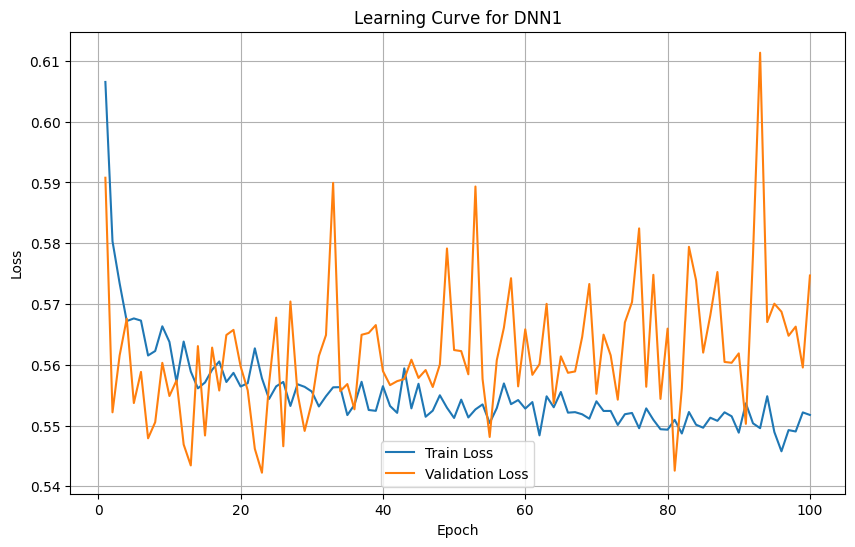

In [9]:
best_params=study.best_params
model = FTTransformer_2(input_dim=X_train_tensor.shape[1],
                      num_heads=best_params["num_heads"],
                      num_layers=best_params["num_layers"],
                      d_model=best_params["d_model"],
                      dropout=best_params["dropout"]).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 58.66%
Precision: 0.4822
Recall: 0.9587
F1 Score: 0.6417
Matthews Correlation Coefficient: 0.3588
Specificity: 0.3525


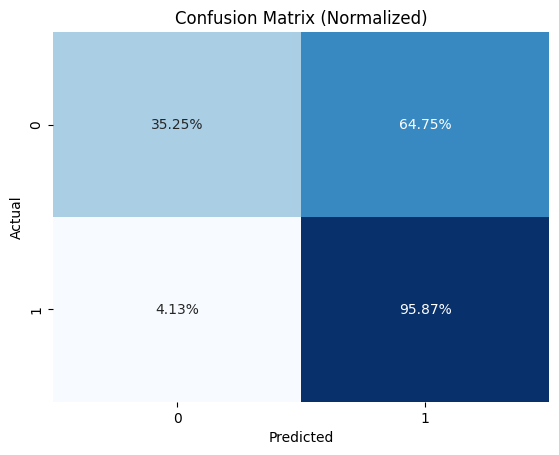

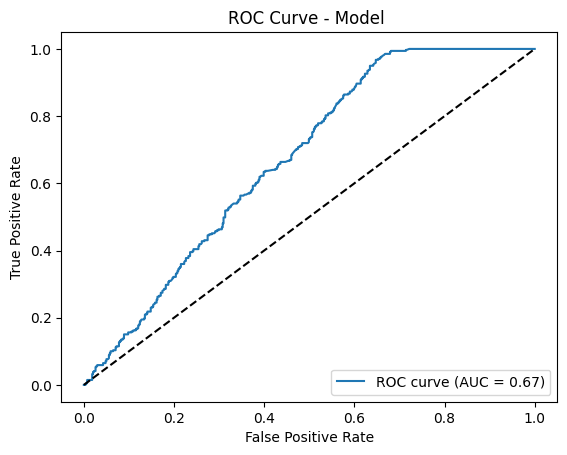

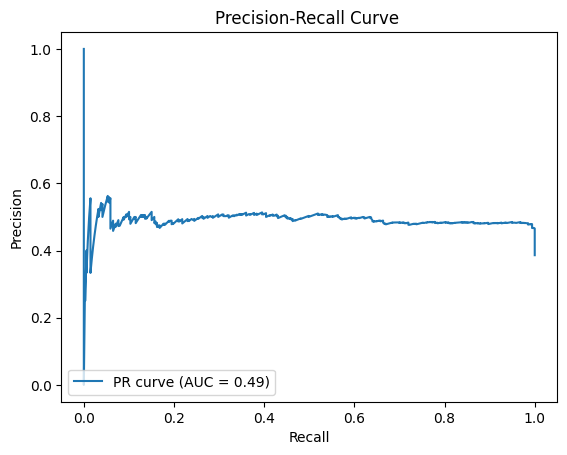

In [10]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >= 0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [11]:
# モデルと構造を保存
torch.save(model, '../../saved_model/FT_transformer_2.pth')
